In [4]:
# Some code segments taken from L4 notebook with updates

# Import necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   

In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
#switch to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
#remove data drive if fresh install needed
%rm -rf /content/drive/MyDrive/Clubs/CAIS++/ASL/data

In [6]:
#set kaggle environment variable and download the dataset
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Clubs/CAIS++/ASL'
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [01:08<00:00, 16.9MB/s]
100% 1.03G/1.03G [01:08<00:00, 16.0MB/s]


In [7]:
#unzip to data/ directory
import zipfile
os.chdir('/content/drive/MyDrive/Clubs/CAIS++/ASL')
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Clubs/CAIS++/ASL/asl-alphabet.zip', 'r')
zip_ref.extractall(path='/content/drive/MyDrive/Clubs/CAIS++/ASL/data')
zip_ref.close()

In [ ]:
#make sure data imported correctly (sometimes would not import correctly)
%cd /content/drive/MyDrive/Clubs/CAIS++/ASL/data/asl_alphabet_train/asl_alphabet_train/space
%ls

In [83]:
#move more images over to testing 
import shutil, random

data_dir='/content/drive/MyDrive/Clubs/CAIS++/ASL/data/'
for char in os.listdir(data_dir+'asl_alphabet_train/asl_alphabet_train'):
  for img in os.listdir(data_dir+'asl_alphabet_train/asl_alphabet_train/'+char):
    r = random.randint(1,10)
    if(r==1):
      shutil.move(data_dir+'asl_alphabet_train/asl_alphabet_train/'+char+'/'+img,data_dir+'asl_alphabet_test/asl_alphabet_test/'+char+'_'+img )

In [ ]:
%cd /content/drive/MyDrive/Clubs/CAIS++/ASL/data/asl_alphabet_test/asl_alphabet_test
%ls

In [8]:
# image transformations

#transforms structure taken from L4 and then modified
#removed resize transforms, resizing to a larger size would just slow the training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

#load in datasets to train and val
data_dir = '/content/drive/MyDrive/Clubs/CAIS++/ASL/data/'
train_set = datasets.ImageFolder(data_dir+'asl_alphabet_train/asl_alphabet_train', transform=data_transforms['train'])
val_set = datasets.ImageFolder(data_dir+'asl_alphabet_train/asl_alphabet_train', transform=data_transforms['val'])

#change if you want a fraction of the dataset instead of whole
frac=1

#partition data between train and val
train_size=int(len(train_set)/frac)
perm = torch.randperm(train_size)
val_percent = 0.15
idx = int(train_size * (1-val_percent))

#make each set a subset of its original based on split 
train_set = torch.utils.data.Subset(train_set, perm[:idx])
val_set = torch.utils.data.Subset(val_set, perm[idx:])

image_datasets = {'train': train_set,
                  'val': val_set}

#dataloaders taken from L4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=3) #changed num workers so as to not freeze (sometimes happens >=4 workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#print all class names in the dataset
class_names = image_datasets['train'].dataset.classes
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
#set requires_grad to false if we are feature extracting, ie just updating the last layer
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
#import model with default weights
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')

#set to false if fine tuning the whole model 
#set to true if only the last layer parameters are updated
feature_extract=True
set_parameter_requires_grad(resnet, feature_extract)

#make fully connected layer
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names)) 

# save model to device
resnet = resnet.to(device)

#cross entropy loss for image classification
criterion = torch.nn.CrossEntropyLoss() 

params = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params.append(param)

optimizer_ft = torch.optim.Adam(params, lr=0.001) 

# decay your learning rate across epochs-- this helps our model converge better and prevents overshooting a local minima
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
#training function
import time 

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            #add to loss list for visual graph
            if(phase=='train'):
              train_losses.append(epoch_loss)
            else:
              val_losses.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

In [12]:
num_epochs = 10

# train the model
model_ft, train_losses, val_losses = train_model(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs)

Epoch 0/9
----------
train Loss: 1.0134 Acc: 0.8272
val Loss: 0.4300 Acc: 0.9268

Epoch 1/9
----------
train Loss: 0.3207 Acc: 0.9472
val Loss: 0.2460 Acc: 0.9532

Epoch 2/9
----------
train Loss: 0.1993 Acc: 0.9667
val Loss: 0.1732 Acc: 0.9658

Epoch 3/9
----------
train Loss: 0.1422 Acc: 0.9768
val Loss: 0.1386 Acc: 0.9701

Epoch 4/9
----------
train Loss: 0.1090 Acc: 0.9818
val Loss: 0.1160 Acc: 0.9743

Epoch 5/9
----------
train Loss: 0.0870 Acc: 0.9859
val Loss: 0.1011 Acc: 0.9754

Epoch 6/9
----------
train Loss: 0.0722 Acc: 0.9886
val Loss: 0.0883 Acc: 0.9786

Epoch 7/9
----------
train Loss: 0.0588 Acc: 0.9923
val Loss: 0.0848 Acc: 0.9794

Epoch 8/9
----------
train Loss: 0.0572 Acc: 0.9928
val Loss: 0.0858 Acc: 0.9793

Epoch 9/9
----------
train Loss: 0.0561 Acc: 0.9929
val Loss: 0.0834 Acc: 0.9801

Training complete in 42m 12s
Best val Acc: 0.980056


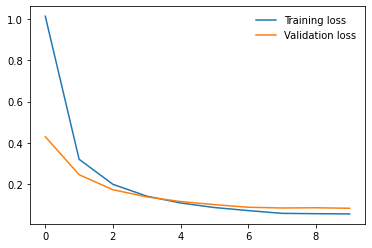

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [14]:
from matplotlib.pyplot import imshow

#define function to show images from training, the model's prediction and the GT (taken from L4 and changed a bit)
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    alph='ABCDEFGHIJKLMNOPQRSTUVWXYZ< _' #using ' ' to represent nothing and using '_' to represent space
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} Ground truth {alph[int(labels[j])]}')
                imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

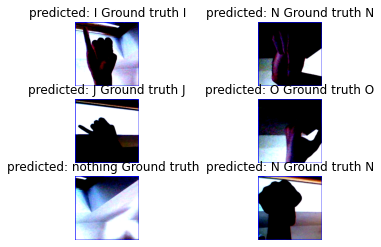

In [15]:
visualize_model(model_ft)
#warnings are fine

In [16]:
from pathlib import Path
from PIL import Image

test_data_path = '/content/drive/MyDrive/Clubs/CAIS++/ASL/data/asl_alphabet_test/asl_alphabet_test/'

#class for evaluating the test dataset and partitioning their labels
class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

In [17]:
#run the model on the testing data
test_dataset = ASLTestDataset(test_data_path, transforms=data_transforms['val'])

total, true = 0,0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])

    total+=1
    if(label==class_names[torch.max(prediction, dim=1)[1]]):
      true+=1

print(f'Test accuracy: {true/total}')


Test accuracy: 0.979793393120672
